# Image segmentation with a U-Net-like architecture

## Prepare paths of input images and target segmentation masks

In [46]:
import os
from typing import Tuple

img_size = (256, 256)
num_classes = 3
batch_size = 16
base_dir = "/home/miki/Documents/studia/2sem/image_processing/project/data"

def get_img_paths(img_size) -> Tuple[list, list]:
    train_x_dir =  os.path.join(base_dir, "train", "patches", f"{img_size[0]}_{img_size[1]}", "image")
    train_y_dir =  os.path.join(base_dir, "train", "patches", f"{img_size[0]}_{img_size[1]}", "label")

    x_img_paths = sorted(
        [
            os.path.join(train_x_dir, fname)
            for fname in os.listdir(train_x_dir)
            if fname.endswith(".png")
        ]
    )
    y_img_paths = sorted(
        [
            os.path.join(train_y_dir, fname)
            for fname in os.listdir(train_y_dir)
            if fname.endswith(".png") and not fname.startswith(".")
        ]
    )

    print("Number of samples:", len(x_img_paths))

    for input_path, target_path in zip(x_img_paths[:10], y_img_paths[:10]):
        print(input_path, "|", target_path)
    
    return x_img_paths, y_img_paths

x_img_paths, y_img_paths = get_img_paths(img_size)

Number of samples: 428
/home/miki/Documents/studia/2sem/image_processing/project/data/train/patches/256_256/image/11879_x40_01_0_1.png | /home/miki/Documents/studia/2sem/image_processing/project/data/train/patches/256_256/label/11879_x40_01_0_1.png
/home/miki/Documents/studia/2sem/image_processing/project/data/train/patches/256_256/image/11879_x40_01_0_2.png | /home/miki/Documents/studia/2sem/image_processing/project/data/train/patches/256_256/label/11879_x40_01_0_2.png
/home/miki/Documents/studia/2sem/image_processing/project/data/train/patches/256_256/image/11879_x40_01_0_3.png | /home/miki/Documents/studia/2sem/image_processing/project/data/train/patches/256_256/label/11879_x40_01_0_3.png
/home/miki/Documents/studia/2sem/image_processing/project/data/train/patches/256_256/image/11879_x40_01_0_4.png | /home/miki/Documents/studia/2sem/image_processing/project/data/train/patches/256_256/label/11879_x40_01_0_4.png
/home/miki/Documents/studia/2sem/image_processing/project/data/train/patc

## What does one input image and corresponding segmentation mask look like?

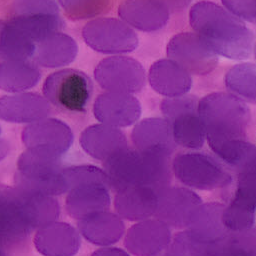

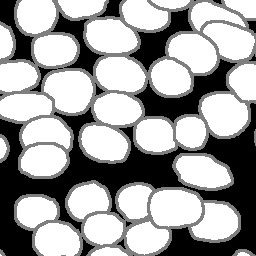

In [47]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps

# Display input image #7
display(Image(filename=x_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(y_img_paths[9]))
display(img)

## Prepare `Sequence` class to load & vectorize batches of data

In [48]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

class BiopsyImages(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, x_img_paths, y_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.x_img_paths = x_img_paths
        self.y_img_paths = y_img_paths

    def __len__(self):
        return len(self.y_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_x_img_paths = self.x_img_paths[i : i + self.batch_size]
        batch_y_img_paths = self.y_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_x_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_y_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y


## Prepare U-Net Xception-style model

In [49]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


## Set aside a validation split

In [50]:
import random

# Split our img paths into a training and a validation set
val_samples = int(0.1 * len(x_img_paths))
random.Random(1337).shuffle(x_img_paths)
random.Random(1337).shuffle(y_img_paths)
train_x_img_paths = x_img_paths[:-val_samples]
train_y_img_paths = y_img_paths[:-val_samples]
val_x_img_paths = x_img_paths[-val_samples:]
val_y_img_paths = y_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = BiopsyImages(
    batch_size, img_size, train_x_img_paths, train_y_img_paths
)
val_gen = BiopsyImages(batch_size, img_size, val_x_img_paths, val_y_img_paths)

## Train the model

In [51]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [52]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

callbacks = [
    # keras.callbacks.ModelCheckpoint("biopsy_segmentation.h5", save_best_only=True, monitor="val_loss")
    keras.callbacks.ModelCheckpoint("biopsy_segmentation.h5", save_best_only=True, monitor="val_accuracy")
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
24/24 [==============================] - 12s 144ms/step - loss: 1.5484 - accuracy: 0.4419 - val_loss: 10.3392 - val_accuracy: 0.9875
Epoch 2/15
24/24 [==============================] - 3s 115ms/step - loss: 0.6459 - accuracy: 0.4407 - val_loss: 1.1245 - val_accuracy: 0.7835
Epoch 3/15
24/24 [==============================] - 3s 115ms/step - loss: 0.5883 - accuracy: 0.4646 - val_loss: 0.7997 - val_accuracy: 0.6464
Epoch 4/15
24/24 [==============================] - 3s 117ms/step - loss: 0.5538 - accuracy: 0.4542 - val_loss: 0.9838 - val_accuracy: 0.8871
Epoch 5/15
24/24 [==============================] - 3s 116ms/step - loss: 0.5403 - accuracy: 0.4606 - val_loss: 1.1364 - val_accuracy: 0.9781
Epoch 6/15
24/24 [==============================] - 3s 123ms/step - loss: 0.5283 - accuracy: 0.4590 - val_loss: 1.1738 - val_accuracy: 0.9918
Epoch 7/15
24/24 [==============================] - 3s 125ms/step - loss: 0.5018 - accuracy: 0.4514 - val_loss: 1.2044 - val_accuracy: 0.9948
Epoc

## Visualize predictions

2/2 [==============================] - 0s 38ms/step


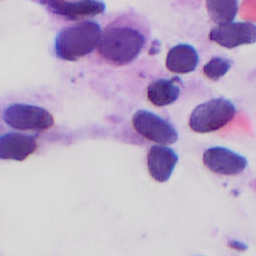

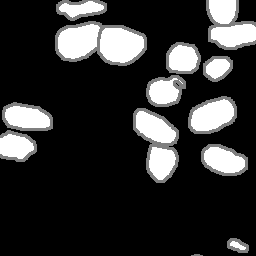

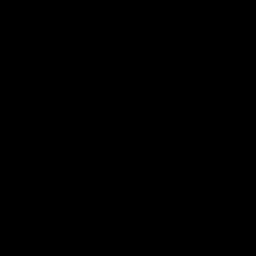

In [53]:
# Generate predictions for all images in the validation set

val_gen = BiopsyImages(batch_size, img_size, val_x_img_paths, val_y_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_x_img_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_y_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

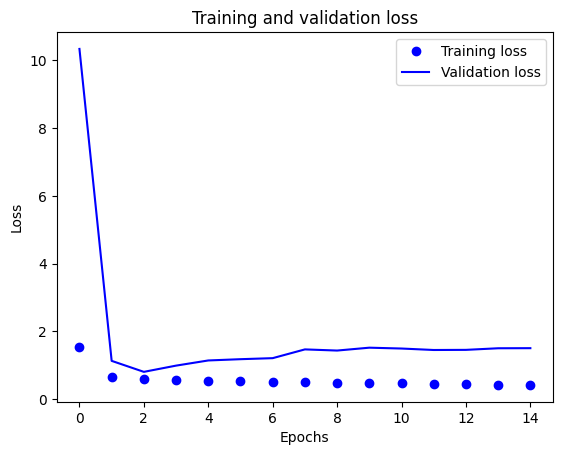

In [54]:
import matplotlib.pyplot as plt

# epochs = 100
# history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

plt.plot(range(epochs), loss_values, 'bo', label='Training loss')
plt.plot(range(epochs), val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

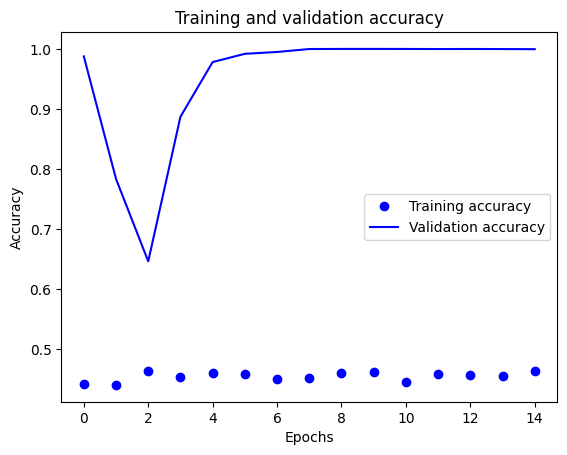

In [55]:
accuracy_values = history.history['accuracy']
val_accuracy_values = history.history['val_accuracy']

plt.plot(range(epochs), accuracy_values, 'bo', label='Training accuracy')
plt.plot(range(epochs), val_accuracy_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Number of tests: 57
/home/miki/Documents/studia/2sem/image_processing/project/data/test/patches/256_256/image/11591_x40_04_0_1.png | /home/miki/Documents/studia/2sem/image_processing/project/data/test/patches/256_256/label/11591_x40_04_0_1.png
/home/miki/Documents/studia/2sem/image_processing/project/data/test/patches/256_256/image/11591_x40_04_1_0.png | /home/miki/Documents/studia/2sem/image_processing/project/data/test/patches/256_256/label/11591_x40_04_1_0.png
/home/miki/Documents/studia/2sem/image_processing/project/data/test/patches/256_256/image/11591_x40_04_1_1.png | /home/miki/Documents/studia/2sem/image_processing/project/data/test/patches/256_256/label/11591_x40_04_1_1.png
/home/miki/Documents/studia/2sem/image_processing/project/data/test/patches/256_256/image/11591_x40_04_1_2.png | /home/miki/Documents/studia/2sem/image_processing/project/data/test/patches/256_256/label/11591_x40_04_1_2.png
/home/miki/Documents/studia/2sem/image_processing/project/data/test/patches/256_256/

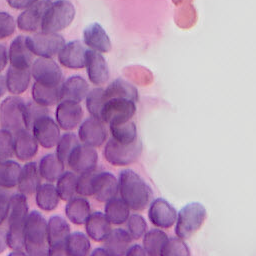

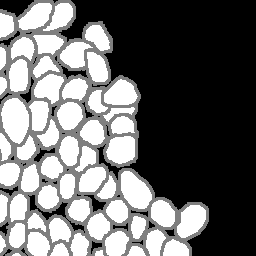

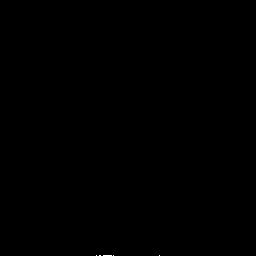

In [56]:

# test_dir = R"C:\Docs\UZ\2sem\image_processing\project\impl\training_images\prepared_test"
# test_train_x_dir =  os.path.join(test_dir, "original")
# test_label_dir =  os.path.join(test_dir, "prepared")
test_x_dir =  os.path.join(base_dir, "test", "patches", f"{img_size[0]}_{img_size[1]}", "image")
test_y_dir =  os.path.join(base_dir, "test", "patches", f"{img_size[0]}_{img_size[1]}", "label")

test_x_paths = sorted(
    [
        os.path.join(test_x_dir, fname)
        for fname in os.listdir(test_x_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

test_y_paths = sorted(
    [
        os.path.join(test_y_dir, fname)
        for fname in os.listdir(test_y_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of tests:", len(test_x_paths))

for input_path, target_path in zip(test_x_paths[10:], test_y_paths[10:]):
    print(input_path, "|", target_path)


test_gen = BiopsyImages(batch_size, img_size, test_x_paths, test_y_paths)
test_preds = model.predict(test_gen)

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(test_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)
    
i = 1

# Display input image
display(load_img(test_x_paths[i]))

# Display ground-truth target mask
display( ImageOps.autocontrast(load_img(test_y_paths[i])))

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

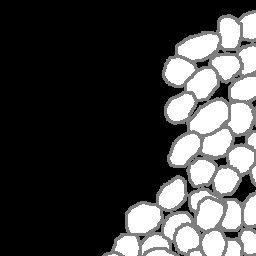

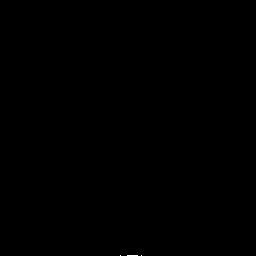

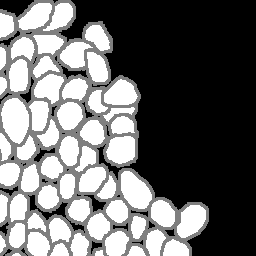

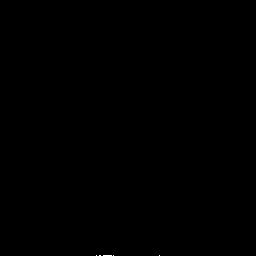

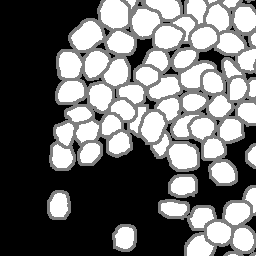

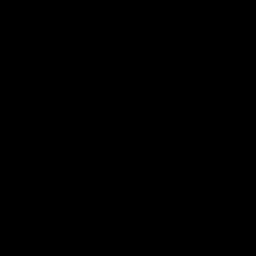

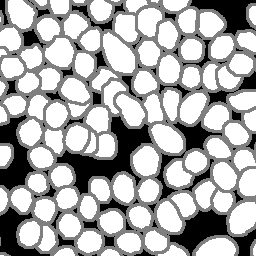

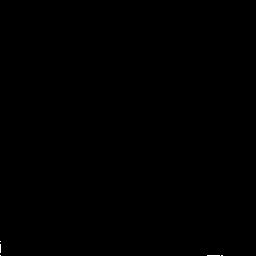

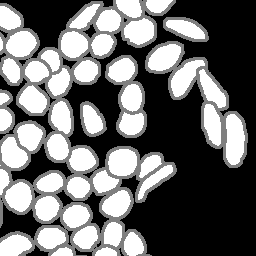

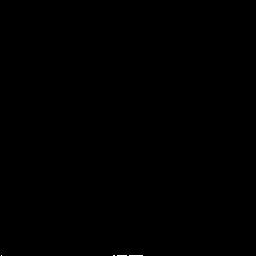

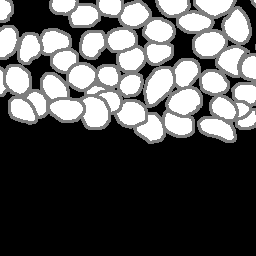

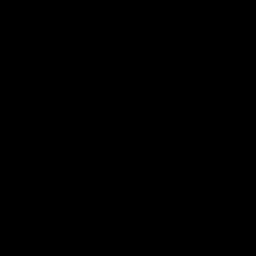

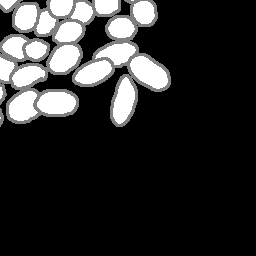

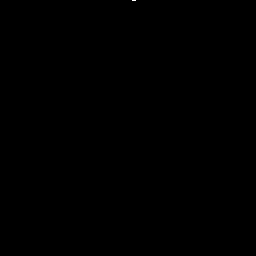

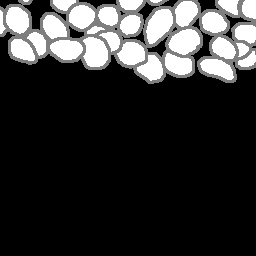

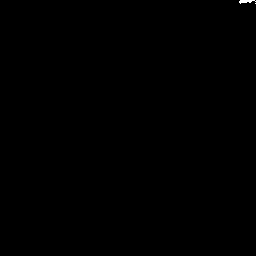

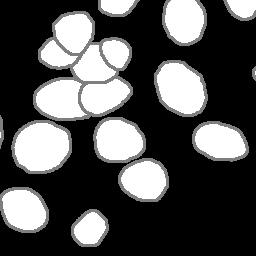

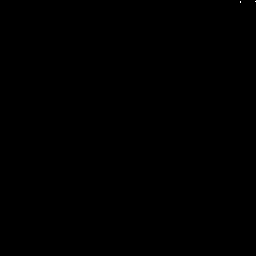

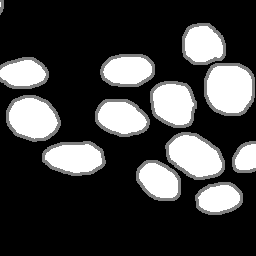

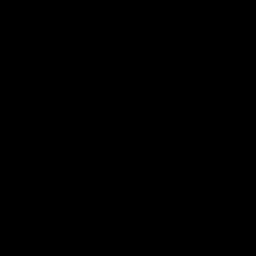

: 

In [57]:
# i = 2

# # Display input image
# display(load_img(test_img_paths[i]))

# # Display ground-truth target mask
# display( ImageOps.autocontrast(load_img(test_labels_paths[i])))

# Display mask predicted by our model
for i in range(10):
    display( ImageOps.autocontrast(load_img(test_y_paths[i])))
    display_mask(i)  # Note that the model only sees inputs at 150x150.

